In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os, random
import sys
sys.path.append('../')
import astropy

from data import KMTData
from data import OGLEData
from data import MOAData

random.seed(42)

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['axes.titlesize'] = 22

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Plot OGLE events

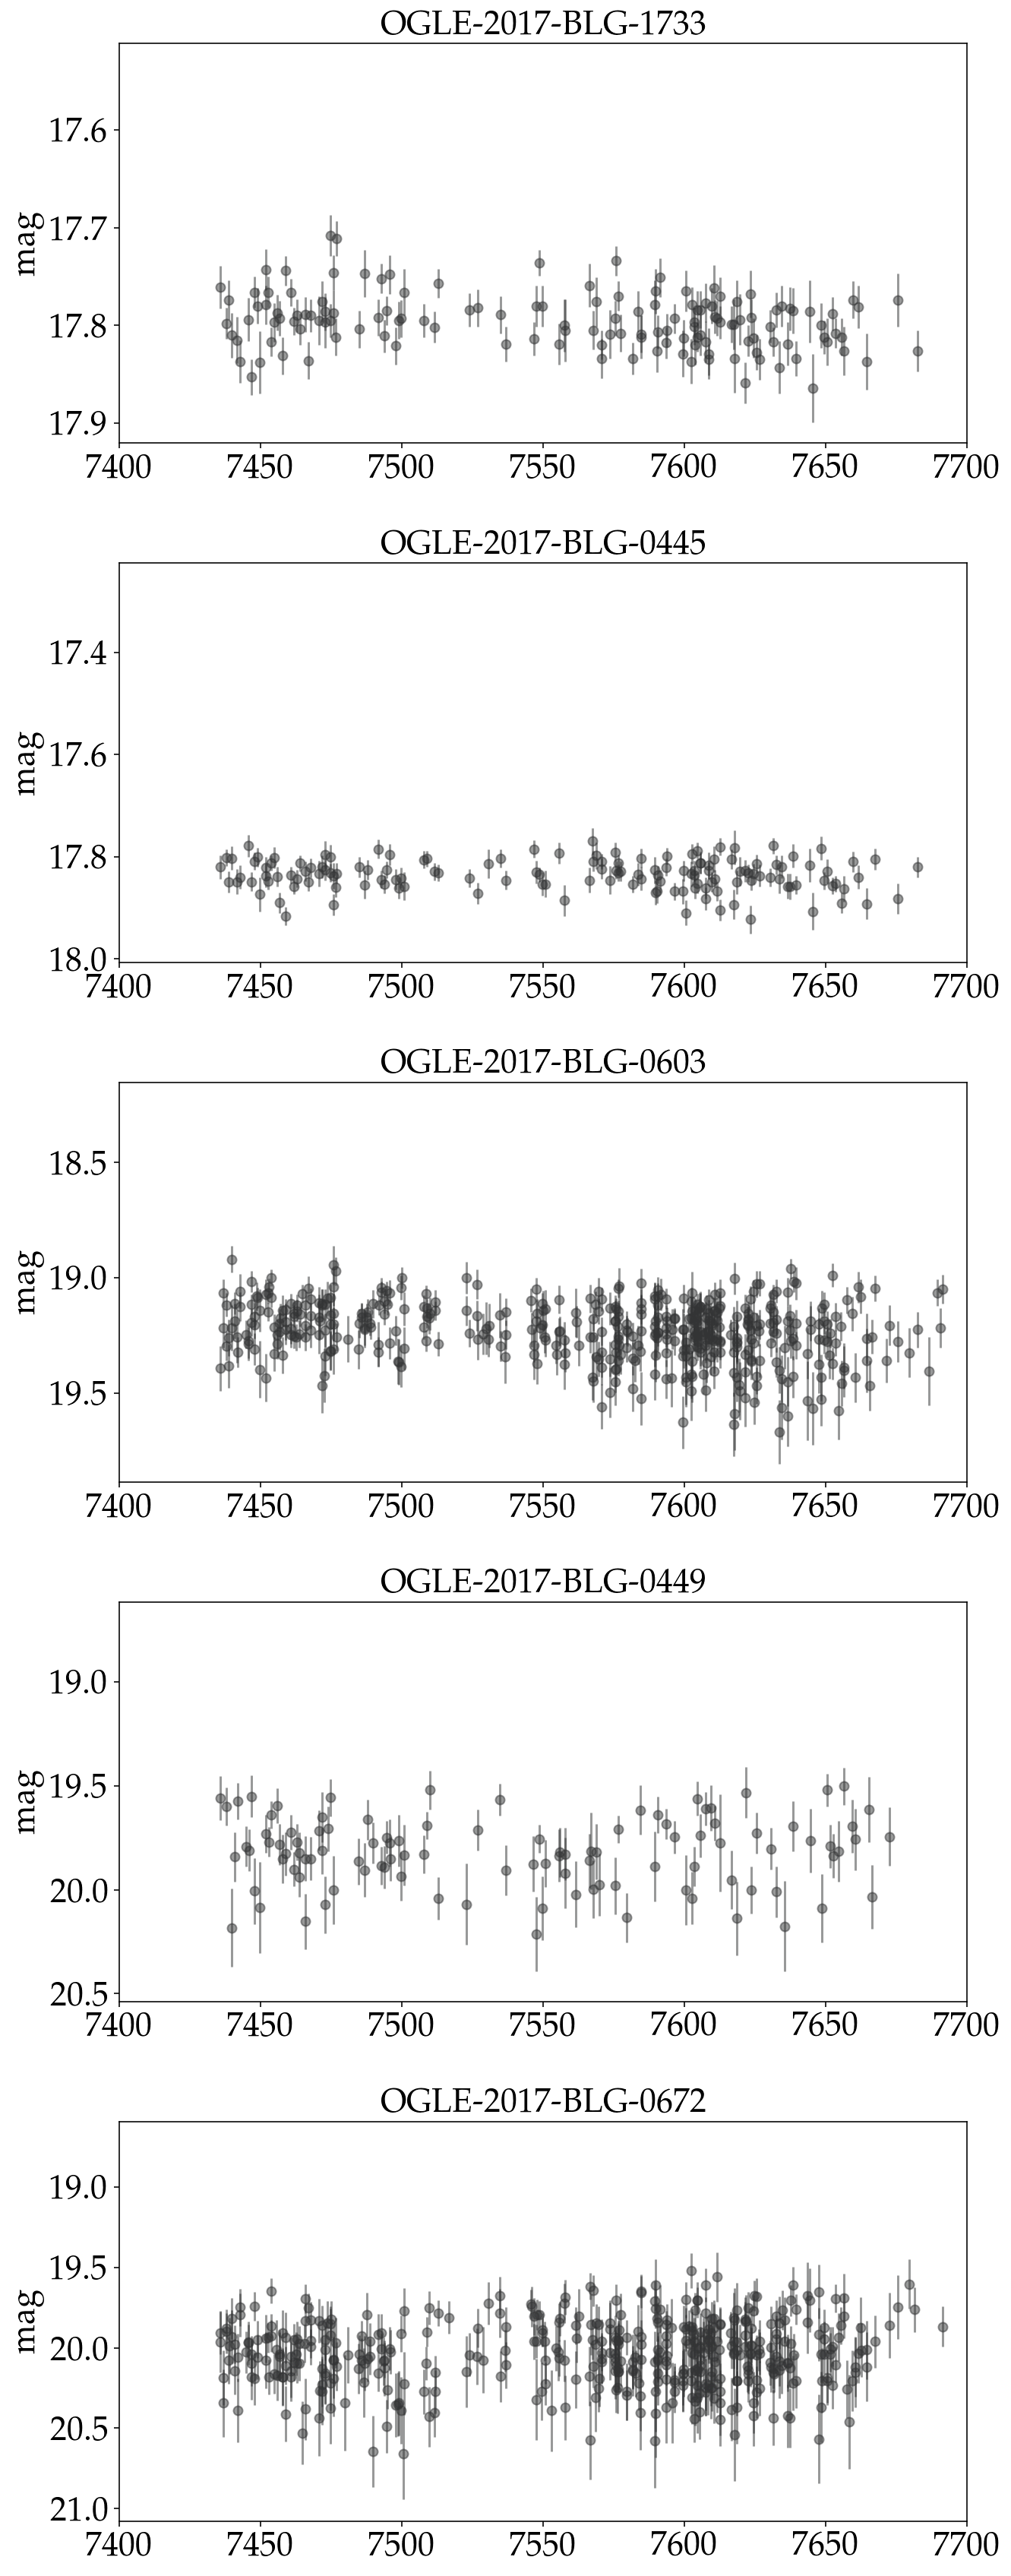

In [2]:
random.seed(33)

events = []  # data for each event

data_path = '/home/star/fb90/data/OGLE_ews/2017/'
dirs = []
for directory in os.listdir(data_path):
    dirs.append(directory)

random.shuffle(dirs)
i = 0
n_events = 5
for directory in dirs:
    if (i < n_events):
        event = OGLEData(data_path + directory)
        events.append(event)
        i = i + 1
        
fig, ax = plt.subplots(n_events, 1, figsize=(10, 30))
fig.subplots_adjust(hspace=0.3)
for idx, event in enumerate(events):
    table = event.tables[0]
    
    # Plot data
    ax[idx].errorbar(table['HJD'] - 2450000, table['mag'], 
        table['mag_err'], fmt='o', color='#333435', ecolor='#333435' , alpha=0.5)
    ax[idx].set_ylabel('mag')
    ax[idx].invert_yaxis()
    ax[idx].set_title(event.event_name)
    ax[idx].set_xlim(left=7400, right=7700)
#     ax[idx].axis('off')


# Plot binary lens events

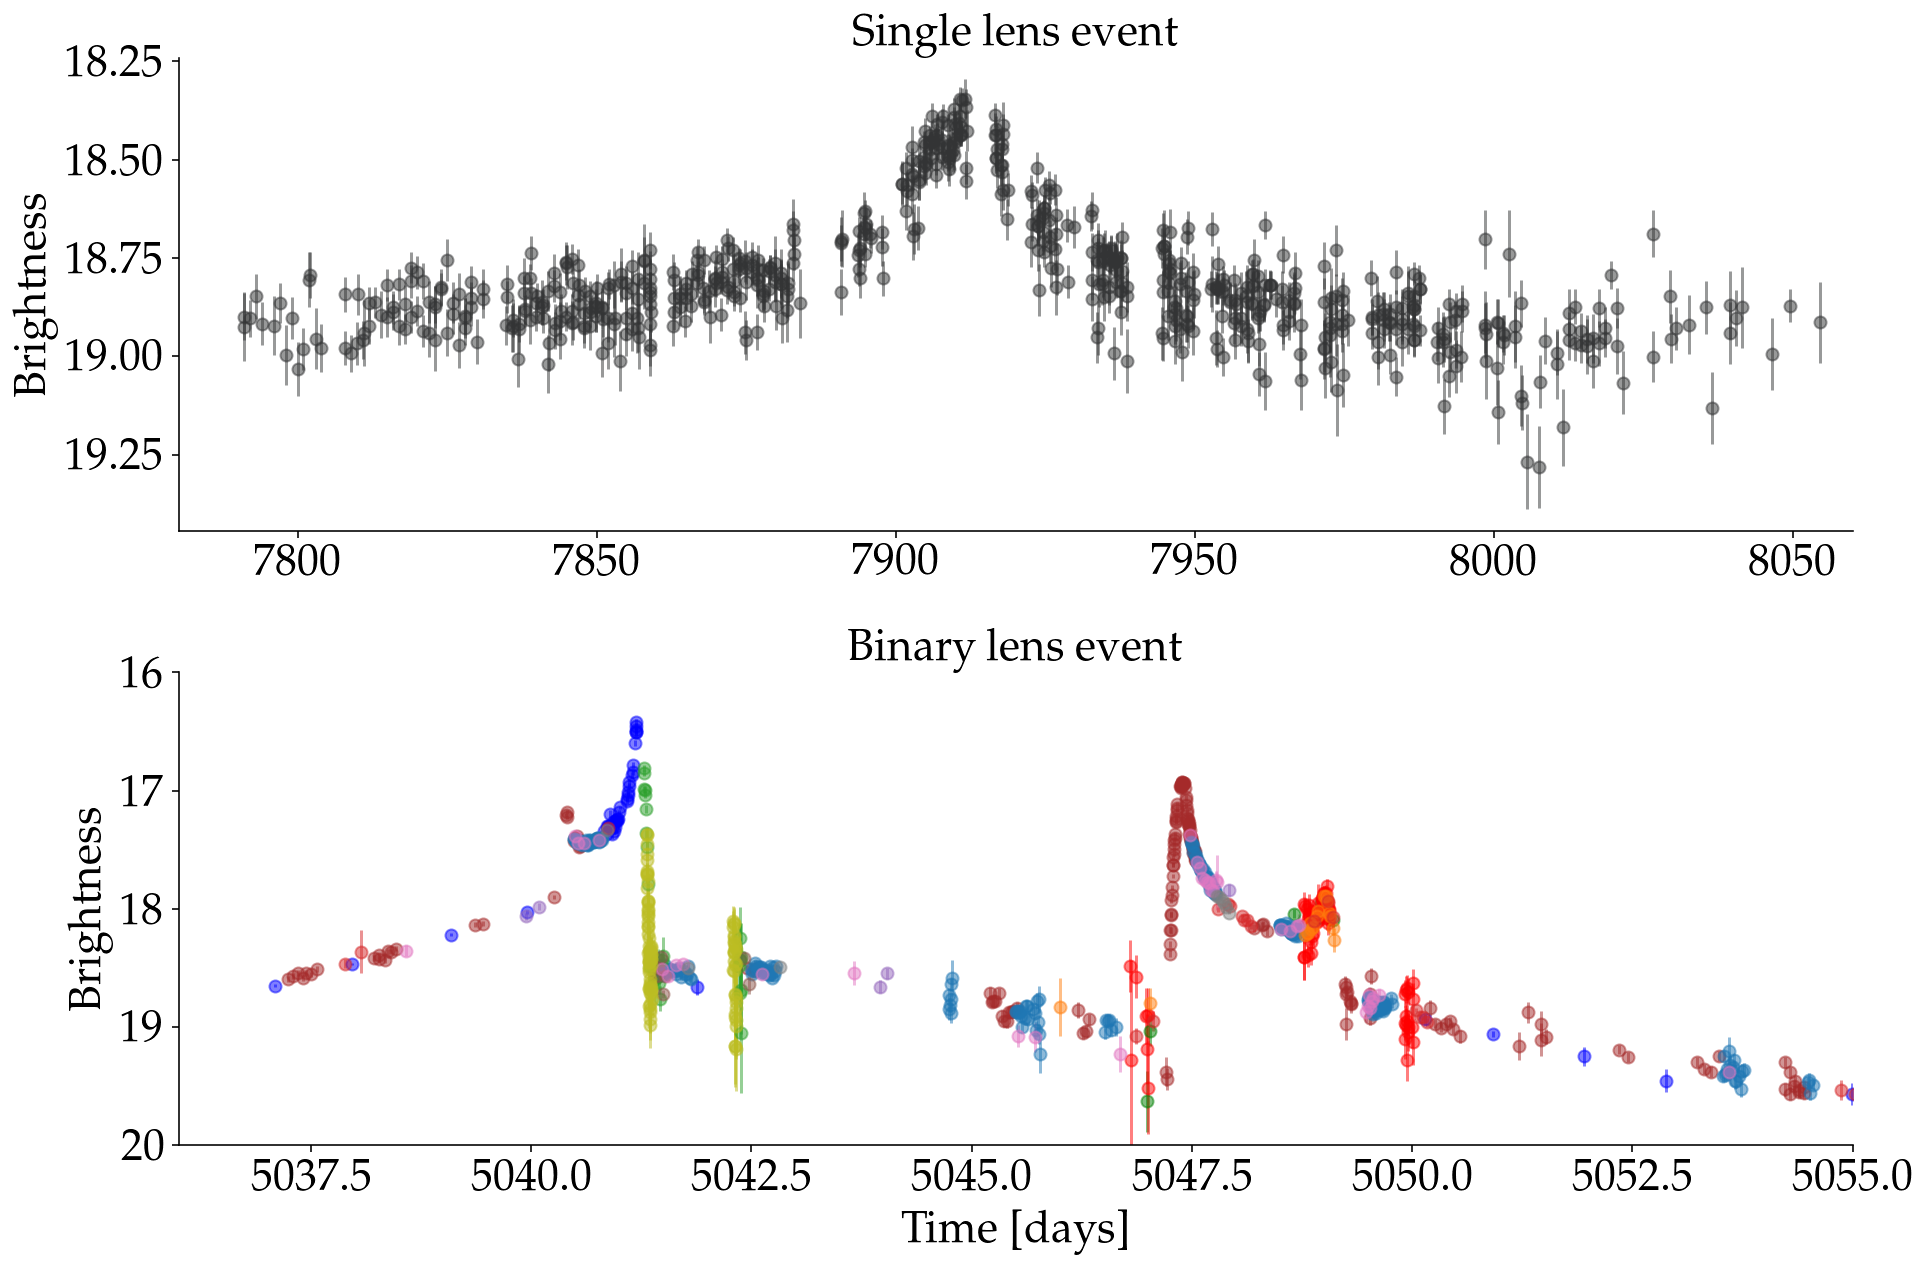

In [5]:
import os                                                                   
import glob  
import pandas as pd
mpl.rcParams['axes.titlesize'] = 22

fig, ax = plt.subplots(2,1, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)
colors= ('blue','green','red', 'brown','C0','C1','C2','C3','C4','C5','C6','C7','C8','C9')
plt.gca().invert_yaxis()

# Plot single OGLE event
event = '/home/star/fb90/data/OGLE_ews/2017/blg-0838/phot.dat' # '2017/0717'

data = pd.read_csv(event, 
                   names=['HJD', 'I_mag', 'I_mag_err', 'seeing_est', 'sky_level'],
                   delim_whitespace=True)
t_single = data['HJD'].values - 2450000
mag = data['I_mag'].values
mag_err = data['I_mag_err'].values

i  = 0
for filename in glob.iglob('MOA-2009-BLG-387Lb/*.tbl'):
    data = np.loadtxt(filename, skiprows=23)
    
    # Name of telescope
    with open(filename) as fp:
        for j, line in enumerate(fp):
            if (j == 14):
                name = line[41:-2]
                break
    fp.close()
    
    t_bin = data[:, 0] - 2450000
    m = data[:, 1]
    m_err = data[:, 2]
    
    ax[1].errorbar(t_bin, m, m_err, fmt='o', color=colors[i], label=name, alpha=0.5)
    
    i = i+1
    
# for a in ax.ravel():
#     a.grid(True)
#     a.legend(prop={'size': 11})

ax[0].errorbar(t_single, mag, mag_err, fmt='o', color='#333435',  ecolor='#333435',
               label='Warsaw University Telescope Las Campanas Observatory (1.3m)', alpha=0.5)
ax[0].set_title('Single lens event')
ax[0].set_ylabel('Brightness')
ax[0].set_xlim(7780, 8060)

ax[1].set_ylabel(r'Brightness')
ax[1].set_xlabel(r'Time [days]')
ax[1].set_xlim(5036, 5055)
ax[1].set_ylim(16, 20.)
ax[1].set_title('Binary lens event')

# This needs to be at the end for some reason
ax[0].invert_yaxis()
ax[1].invert_yaxis()

for a in ax.ravel():
    # Hide the right and top spines
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    a.yaxis.set_ticks_position('left')
    a.xaxis.set_ticks_position('bottom')

plt.savefig('example_lightcurves.png', bbox_inches='tight')

# Parallax animation

In [4]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u

event = OGLEData('/home/star/fb90/data/OGLE_ews/2017/blg-0525')

start = Time(event.tables[0]['HJD'][0], format='jd')
stop = Time(event.tables[0]['HJD'][-1], format='jd')

epochs={'start':start.iso[:10], 'stop':stop.iso[:10], 'step':'6h'}
obj = Horizons(id='399', id_type='id', epochs=epochs)
elements = obj.elements()

In [5]:
coordinates_ecliptic = event.coordinates.transform_to('geocentrictrueecliptic')
lambda_0 = coordinates_ecliptic.lon.value*(np.pi/180)
beta_0  = coordinates_ecliptic.lat.value*(np.pi/180)

t = np.array(elements['datetime_jd']) # JD
e = np.array(elements['e'])
tp = np.array(elements['Tp_jd']) # JD
n = (2*np.pi/365.25) # mean motion
Phi_gamma = (77.86)*np.pi/180 # true anomaly at vernal eq. on J2000
r_sun = 1 - e*np.cos(n*(t - tp)) # to 1st order in e
lambda_sun = n*(t - tp) - Phi_gamma + 2*e*np.sin(n*(t - tp)) # to 1st order in e

gamma_w = r_sun*np.sin((lambda_sun - lambda_0))
gamma_n = r_sun*np.sin(beta_0)*np.cos(lambda_sun - lambda_0)

gamma_w_dot = n*((1 + e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)+\
    e*np.sin(n*(t - tp))*np.sin(lambda_sun - lambda_0))
gamma_n_dot = -n*np.sin(beta_0)*((1 + e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0) -\
    e*np.sin(n*(t - tp))*np.cos(lambda_sun - lambda_0))

gamma_w_ddot = -n**2*(1 + 2*e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0)
gamma_n_ddot = -n**2*np.sin(beta_0)*(1 + 2*e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)

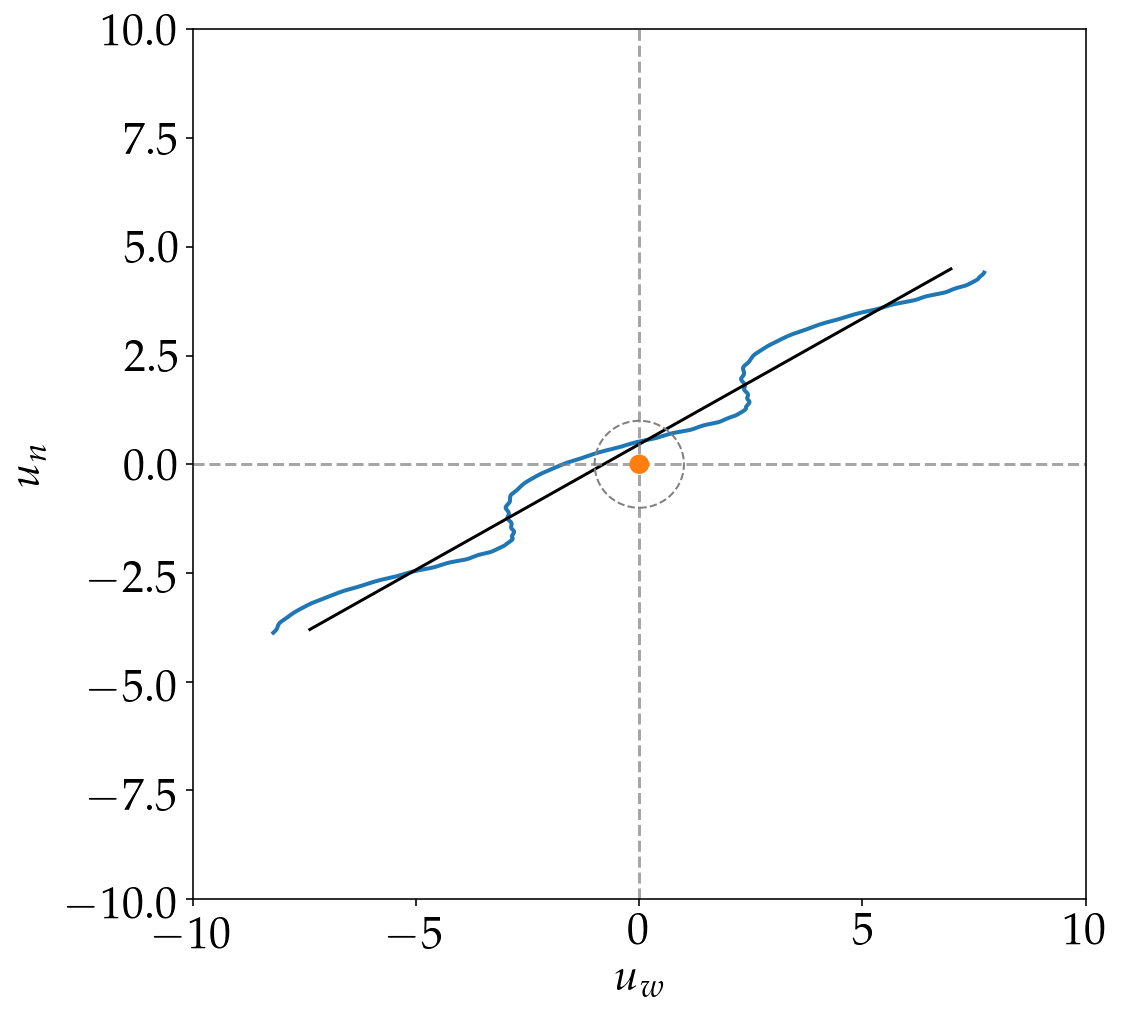

In [19]:
def compute_u(t_, u0, t0, omegaE, psi, piE):
    gamma_w_interp = np.interp(t_, t, gamma_w)
    gamma_n_interp = np.interp(t_, t, gamma_n)
    
    u_w = -u0*np.sin(psi) - omegaE*(t_ - t0)*np.cos(psi) + piE*gamma_w_interp
    u_n = u0*np.cos(psi) - omegaE*(t_ - t0)*np.sin(psi) + piE*gamma_n_interp

    return u_w, u_n
    
t_ = np.linspace(t[0], t[-1], 380)

t0 = 0.5*(t[-1] + t[0])
tE = 60.

u_w, u_n = compute_u(t_, 0.4, t0, 1/tE, 30*(np.pi/180) , 1.)
u_w_linear, u_n_linear = compute_u(t_, 0.4, t0, 1/tE, 30*(np.pi/180), 0.)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(u_w, u_n, color='C0', lw=2.)
ax.plot(u_w_linear, u_n_linear, color='black', lw=1.5)
ax.axvline(0., color='grey', linestyle='dashed', alpha=0.7)
ax.axhline(0., color='grey', linestyle='dashed', alpha=0.7)
# ax.grid()
ax.set_xlabel(r'$u_w$')
ax.set_ylabel('$u_n$')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


circle = plt.Circle((0., 0.), 0.2, color='C1', zorder=2)
circle_einstein = plt.Circle((0., 0.), 1., color='grey', zorder=2, fill=False, linestyle='dashed')
ax.add_artist(circle)
ax.add_artist(circle_einstein)


def mag(u):
    A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    return A(u)

mag_u = mag(np.sqrt(u_w**2 + u_n**2))

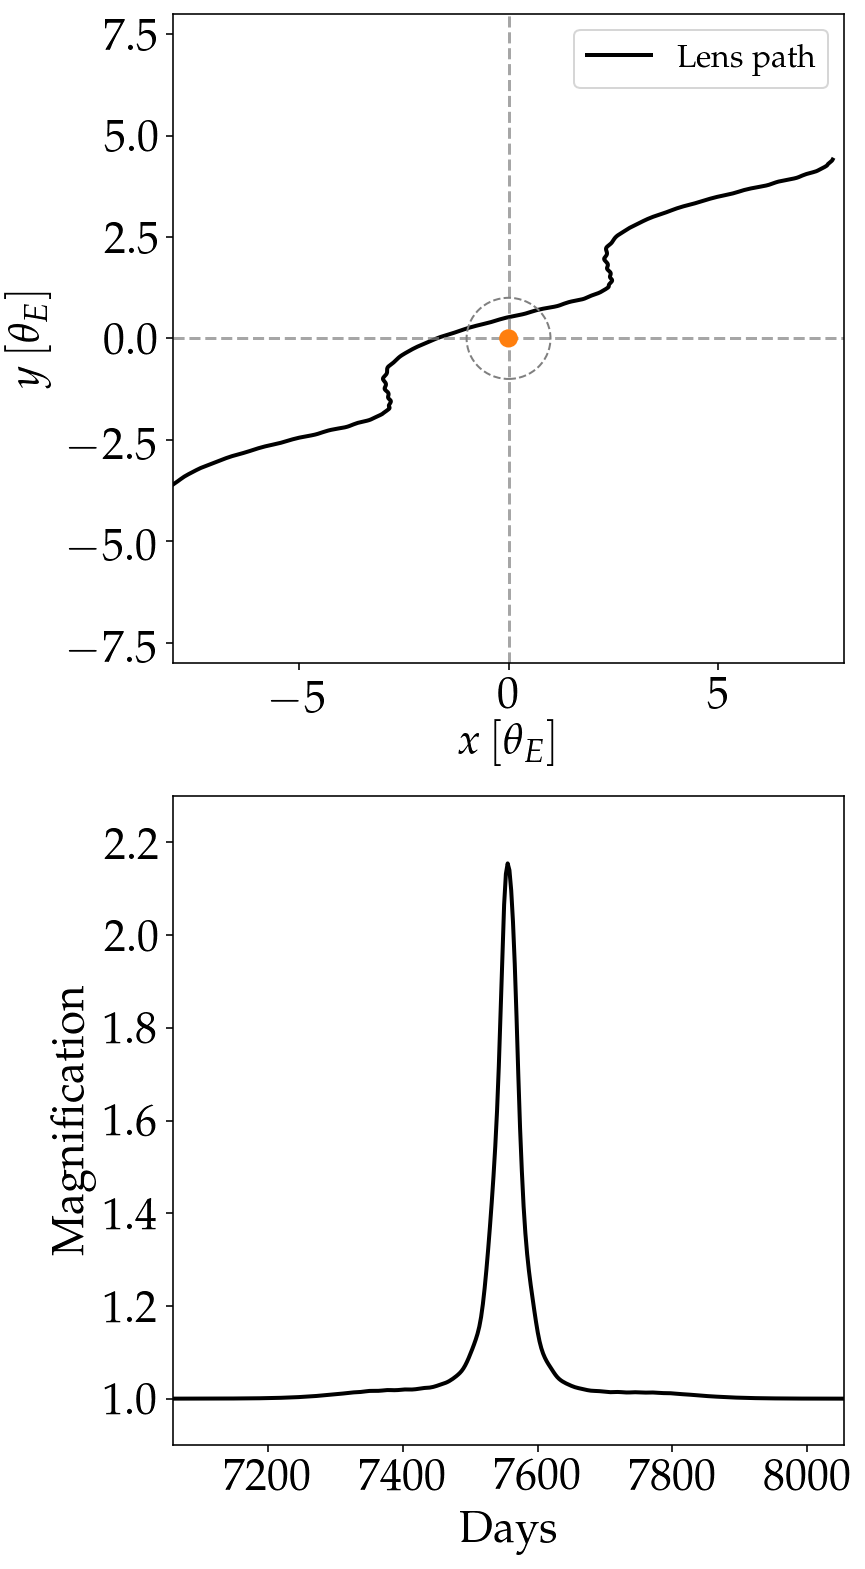

In [20]:
import matplotlib.animation as animation 

fig, ax = plt.subplots(2, 1, figsize=(6,11)) 
left, bottom, width, height = [0.06, 0.43, 0.45, 0.45]
# ax2 = fig.add_axes([left, bottom, width, height])

ax[1].set_xlim(t_[0] - 2450000, t_[-1] - 2450000)
ax[1].set_ylim(0.9, 2.3)

ax[0].set_xlim(-8, 8)
ax[0].set_ylim(-8, 8)


lines = []
lines.append(ax[1].plot([], [], lw=2, color='black')[0])
lines.append(ax[0].plot([], [], lw=2, label='Lens path', color='black')[0])

# initialization function 
def init(): 
    lines[0].set_data([], []) 
    lines[1].set_data([], []) 
    
    return lines

x1,y1 = [],[]
x2,y2 = [],[]

# animation function 
def animate(i):    
    # x, y values to be plotted 
    x = t_[i] - 2450000
    y = mag_u[i]
    
    x1.append(x) 
    y1.append(y)
    
    x = u_w[i] 
    y = u_n[i]
     
    x2.append(x) 
    y2.append(y) 
    
    lines[0].set_data(x1, y1) 
    lines[1].set_data(x2, y2) 

    return lines

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
    frames=len(u_w), interval=20, blit=True) 

ax[0].axvline(0., color='grey', linestyle='dashed', alpha=0.7)
ax[0].axhline(0., color='grey', linestyle='dashed', alpha=0.7)

circle = plt.Circle((0., 0.), 0.2, color='C1', zorder=2)
circle_einstein = plt.Circle((0., 0.), 1., color='grey', zorder=2, fill=False, linestyle='dashed')
ax[0].add_artist(circle)
ax[0].add_artist(circle_einstein)

ax[0].legend(prop={'size': 16})
ax[0].set_xlabel(r'$x\,[\theta_E]$')
ax[0].set_ylabel(r'$y\,[\theta_E]$')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Magnification')
plt.tight_layout()

# save the animation as mp4 video file 
anim.save('microlensing_u.gif', writer='imagemagick') 